# Second 6hr Sun observation analysis

In [1]:
import ugradio
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.table as Table
from datetime import datetime
from datetime import timedelta
import time
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy

%matplotlib inline
plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 17})

No module named 'rtlsdr'


## Loading in the data

Data was collected on March 31, 2022 beginning at 12:04:05 pm and ending on 18:03:48 pm (PST).

In [2]:
volts, times = np.load('Data/sun_6hr_data_pt2.npy')

### Getting the times of observation:

In [3]:
### Getting initial times ###

beginning_time = min(times)
ending_time = max(times)

beginning_local_time = ugradio.timing.local_time(beginning_time)
ending_local_time = ugradio.timing.local_time(ending_time)

beginning_jd = ugradio.timing.julian_date(beginning_time)
ending_jd = ugradio.timing.julian_date(ending_time)


print('Beginning time in local time (PST):', beginning_local_time, '\nEnding time in local time (PST):', ending_local_time)

print('\nBeginning JD:', beginning_jd, '\nEnding JD:', ending_jd)


Beginning time in local time (PST): Thu Mar 31 12:04:05 2022 
Ending time in local time (PST): Thu Mar 31 18:03:48 2022

Beginning JD: 2459670.294506975 
Ending JD: 2459670.5443090596


In [4]:
### Latitude and Longitude of Observations ###

lon, lat = ugradio.coord.nch.lon, ugradio.coord.nch.lat

In [5]:
### JDs, LSTs, initial ra and dec, hour angles ###

jds = ugradio.timing.julian_date(times) # julian dates
LSTs = ugradio.timing.lst(jd=jds, lon=lon) # local sidereal times

ra_deg, dec_deg = ugradio.coord.sunpos(beginning_jd) # initial ra and dec, degrees
ra_rad, dec_rad = (np.pi/180)*ra_deg, (np.pi/180)*dec_deg #radians
has = LSTs - ra_rad # hour angles

## Looking for Fringes

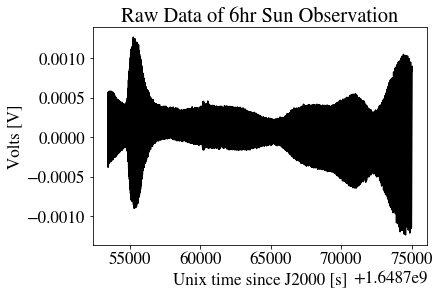

In [6]:
plt.figure()
plt.title('Raw Data of 6hr Sun Observation')
plt.plot(times, volts, 'k')
plt.xlabel('Unix time since J2000 [s]')
plt.ylabel('Volts [V]')
plt.show()

In [7]:
v_inter = np.median(np.diff(times)) 

freqs = np.fft.fftfreq(len(times), v_inter)

power = np.abs(np.fft.fft(volts))**2

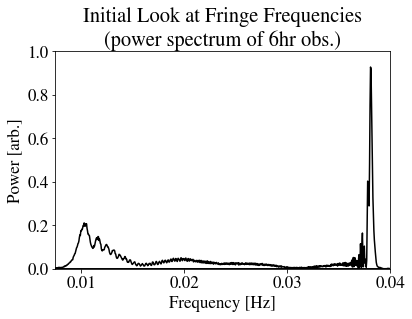

In [8]:
plt.figure()
plt.title('Initial Look at Fringe Frequencies\n(power spectrum of 6hr obs.)')
plt.plot(freqs, power, 'k')
plt.xlim(0.0075,0.04)
plt.ylim(0,1)
plt.ylabel('Power [arb.]')
plt.xlabel('Frequency [Hz]')
plt.show()

In [9]:
def pow_fft(arr):
    return np.fft.fftshift(np.abs(np.fft.fft(arr))**2)

def freq(arr, dt):
    return np.fft.fftshift(np.fft.fftfreq(len(arr), dt))


def split_data(data, time, num_splits):
    n = len(data)
    split_size = n // num_splits
    data_splits = []
    freq_splits = []
    for i in range(num_splits):
        data_frac = data[i*split_size:(i+1)*split_size]
        time_frac = time[i*split_size:(i+1)*split_size]
        dt = np.mean(np.diff(time_frac))
        frequency = freq(time_frac, dt)
        pow_frac = pow_fft(data_frac)
        
        data_splits.append(pow_frac)
        freq_splits.append(frequency)
        
    return data_splits, freq_splits

In [10]:
split_power, split_freqs = split_data(volts, times, 24)

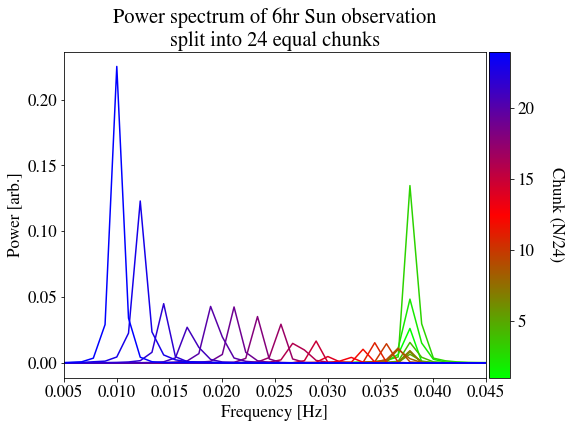

In [11]:
df

### Expected fringe frequencies

In [12]:
# def exp_fringe_freq(hs0, dec, Bew, Bns, L):
#     λ = 2.5e-2 # m
#     term1 = (Bew/λ)*np.cos(dec)*np.cos(hs0) 
#     term2 = (Bns/λ)*np.sin(L)*np.cos(dec)*np.sin(hs0)
#     ff = term1 -  term2
#     return ff

In [13]:
# Bew = 20  # m
# Bns = 0

# lat, lon = ugradio.nch.lat, ugradio.nch.lon # degrees
# L = (np.pi/180)*lat # converting to radians

# α, δ = ugradio.coord.sunpos(beginning_jd) # both calculated in degrees -- ra, dec calculated at beginning of observation
# α = (np.pi/180)*α # converted to radians
# δ = (np.pi/180)*δ # converted to radians
# # ha = α*(24/(2*np.pi)) # convert ra to hour angle (hrs)

# LST = ugradio.timing.lst(beginning_jd, lon) #radians
# h_s = LST - α

# print('Expected fringe frequency:', exp_fringe_freq(h_s, δ, Bew, Bns, L)) ## Hz??
# ## off by 1e-3??

# Analysis

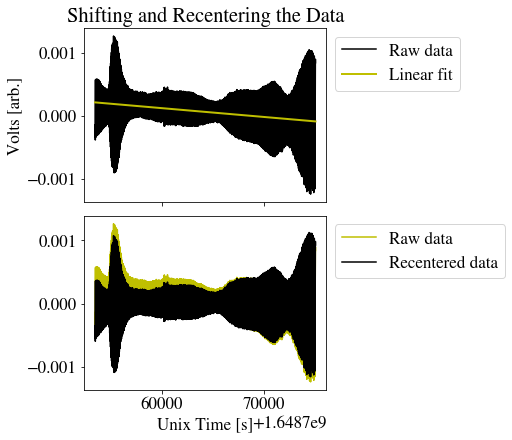

In [15]:
### Shifting data and recentering to correct for bias ###

linear_model = np.polyfit(times, volts, deg=1)
m, b = linear_model

fig, (ax0, ax1) = plt.subplots(2,1, figsize=(7,6), constrained_layout=True, sharex=True)

ax0.set_title('Shifting and Recentering the Data')

ax0.plot(times, volts, color='k', label='Raw data')
ax0.plot(times, m*times + b, 'y', lw=2, label='Linear fit')
ax0.set_ylabel('Volts [arb.]')
ax0.legend(bbox_to_anchor=(1,1), loc='upper left')

ax1.plot(times, volts, color='y', label='Raw data')
ax1.plot(times, volts - (m*times + b), color='k', label='Recentered data')
ax1.set_xlabel('Unix Time [s]')
ax1.legend(bbox_to_anchor=(1,1), loc='upper left')

plt.show()

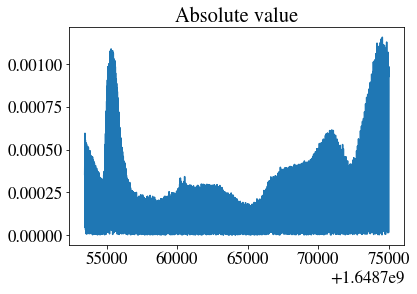

In [16]:
### Taking absolute value of shifted data ###

centered_volts = volts - (m*times + b)

abs_centered_volts = np.abs(centered_volts)

plt.figure()
plt.title('Absolute value')
plt.plot(times, abs_centered_volts)
plt.show()

In [17]:
# plt.figure()
# plt.plot(times, recentered_volts, label='centered')
# plt.plot(times, abs_centered_volts, alpha=0.7, label='abs. val + centered')
# plt.legend(bbox_to_anchor=(1,1), loc='upper left')
# plt.show()

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1390: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


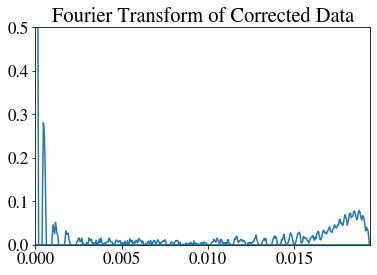

In [18]:
### FFT ###

dt = np.mean(np.diff(times))

fft_volts = np.fft.fft(abs_centered_volts)
freqs = np.fft.fftfreq(len(times), dt)

plt.figure()
plt.title('Fourier Transform of Corrected Data')
plt.plot(freqs, fft_volts)
plt.ylim(0, 0.5)
plt.xlim(0, 0.0194)
plt.show()

In [19]:
### Fourier Filtering ###
# The envelope exists in the low frequencies

fft_volts[np.where(freqs > 0.0194)] = 0
fft_volts[np.where(freqs < -0.0194)] = 0

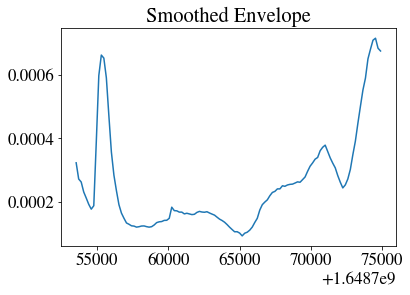

In [39]:
### Envelope ###

abs_envelope = np.fft.ifft(fft_volts)


# Envelope needs to be smoothed #

def split_envelope(data, time, num_splits):
    n = len(data)
    split_size = n // num_splits
    data_splits = []
    freq_splits = []
    for i in range(num_splits):
        data_frac = data[i*split_size:(i+1)*split_size]
        time_frac = time[i*split_size:(i+1)*split_size]
        
        data_splits.append(data_frac)
        freq_splits.append(time_frac)
        
    return data_splits, freq_splits

split_env, split_times = split_envelope(abs_envelope, times, 122)

means_split_env = []
means_split_times = []
for i in range(len(split_env)):
    mean_env = np.mean(split_env[i])
    mean_time = np.mean(split_times[i])
    means_split_env.append(mean_env)
    means_split_times.append(mean_time)

smoothed_envelope = np.array(means_split_env)
smoothed_times = np.array(means_split_times)

plt.figure()
plt.title('Smoothed Envelope')
plt.plot(smoothed_times, smoothed_envelope)
plt.show()

In [40]:
smoothed_envelope.shape, type(smoothed_envelope)

((122,), numpy.ndarray)

/usr/lib/python3/dist-packages/matplotlib/collections.py:1342: ComplexWarning: Casting complex values to real discards the imaginary part
  seg = np.asarray(seg, float)


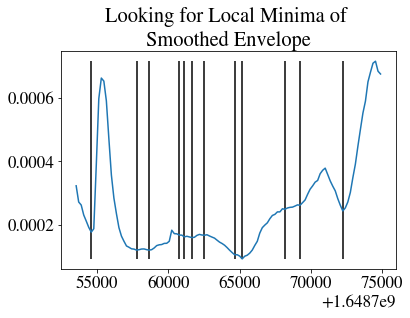

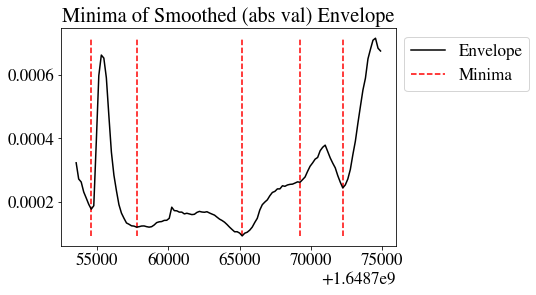

In [57]:
### Finding Local Minima of (Smoothed) Envelope ###

import scipy.signal as ss
local_minimum = ss.argrelmin(smoothed_envelope)

plt.figure()
plt.title('Looking for Local Minima of \nSmoothed Envelope')
plt.plot(smoothed_times, smoothed_envelope)
for i in range(len(local_minimum[0])):
    plt.vlines(smoothed_times[local_minimum[0][i]], min(smoothed_envelope), max(smoothed_envelope))
plt.show()

local_mins = np.array([local_minimum[0][0], 
                       local_minimum[0][1], 
                       local_minimum[0][8], 
                       local_minimum[0][10], 
                       local_minimum[0][11]])
# local_mins.shape

plt.figure()
plt.plot(smoothed_times, smoothed_envelope, 'k')
for i in range(len(local_mins)):
    plt.vlines(smoothed_times[local_mins[i]], min(smoothed_envelope), max(smoothed_envelope), 'r', linestyles='--')
labels = ['Envelope', 'Minima']
plt.legend(labels=labels, bbox_to_anchor=(1,1), loc='upper left')
plt.title('Minima of Smoothed (abs val) Envelope')
plt.show()

In [58]:
### Changing the sign of parts of the envelope ###

chunk1 = smoothed_envelope[0:local_mins[0]]
chunk1 = chunk1*-1
chunk2 = smoothed_envelope[local_mins[0]:local_mins[1]]
chunk3 = smoothed_envelope[local_mins[1]:local_mins[2]]
chunk3 = chunk3*-1
chunk4 = smoothed_envelope[local_mins[2]:local_mins[3]]
chunk5 = smoothed_envelope[local_mins[3]:local_mins[4]]
chunk5 = chunk5*-1
chunk6 = smoothed_envelope[local_mins[4]:]

envelope = np.append(chunk1, chunk2)
envelope = np.append(envelope, chunk3)
envelope = np.append(envelope, chunk4)
envelope = np.append(envelope, chunk5)
envelope = np.append(envelope, chunk6)

envelope.shape


(122,)

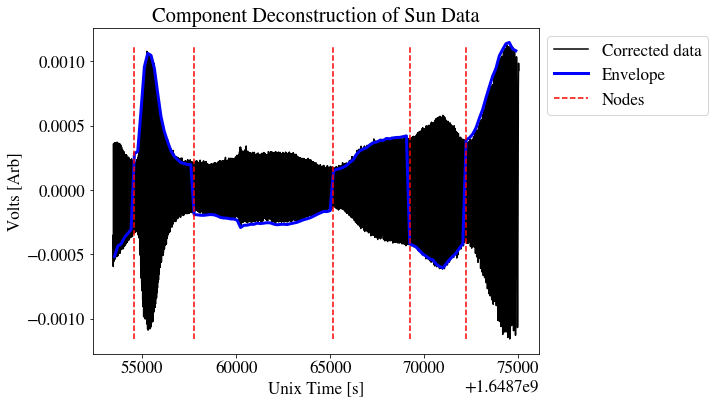

In [63]:
plt.figure(figsize=(8,6))
for i in range(len(local_mins)):
    plt.vlines(smoothed_times[local_mins[i]], min(centered_volts), max(centered_volts), color='red', linestyles='--', zorder=6)
plt.plot(times, centered_volts, 'k')
plt.plot(smoothed_times, envelope*1.6, 'b', lw=3)
plt.title('Component Deconstruction of Sun Data')
plt.xlabel('Unix Time [s]')
plt.ylabel('Volts [Arb]')
labels = ['Corrected data', 'Envelope', 'Nodes']
plt.legend(labels=labels, bbox_to_anchor=(1,1), loc='upper left')
plt.show()

5 5


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


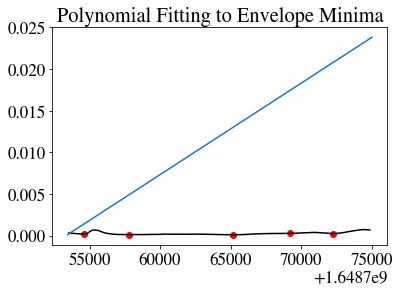

In [101]:
### Polynomial Fitting to Envelope Minima ###

plt.figure()
plt.title('Polynomial Fitting to Envelope Minima')
plt.plot(smoothed_times, smoothed_envelope, 'k')
for i in range(len(local_mins)):
    plt.scatter(smoothed_times[local_mins[i]], smoothed_envelope[local_mins[i]], color='red')

times_mins = [] 
envelope_mins = []
for i in range(len(local_mins)):
    times_min, envelope_min = smoothed_times[local_mins[i]], smoothed_envelope[local_mins[i]]
    times_mins.append(times_mins), envelope_mins.append(envelope_min)
print(len(times_mins), len(envelope_mins))


p1 = np.polyfit(time_mins, envelope_mins, deg=6)
# p1
p1y = np.polyval(p1, times)
plt.plot(times, p1y)
    

